<a href="https://colab.research.google.com/github/Murad-pitafi/Computer-Vision/blob/main/Feature_Extraction_for_Classification_Using_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 213kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.36MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.2MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [2]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded


In [3]:
autoencoder = Autoencoder(latent_dim=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


In [4]:
epochs = 10
for epoch in range(epochs):
    autoencoder.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.view(-1, 28 * 28)
        optimizer.zero_grad()
        recon, _ = autoencoder(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset):.4f}')


Epoch 1, Loss: 0.0049
Epoch 2, Loss: 0.0047
Epoch 3, Loss: 0.0046
Epoch 4, Loss: 0.0046
Epoch 5, Loss: 0.0046
Epoch 6, Loss: 0.0046
Epoch 7, Loss: 0.0046
Epoch 8, Loss: 0.0046
Epoch 9, Loss: 0.0046
Epoch 10, Loss: 0.0046


In [5]:
autoencoder.eval()
latent_features = []
labels = []
with torch.no_grad():
    for data, label in test_loader:
        _, encoded = autoencoder(data)
        latent_features.append(encoded)
        labels.append(label)

latent_features = torch.cat(latent_features).numpy()
labels = torch.cat(labels).numpy()


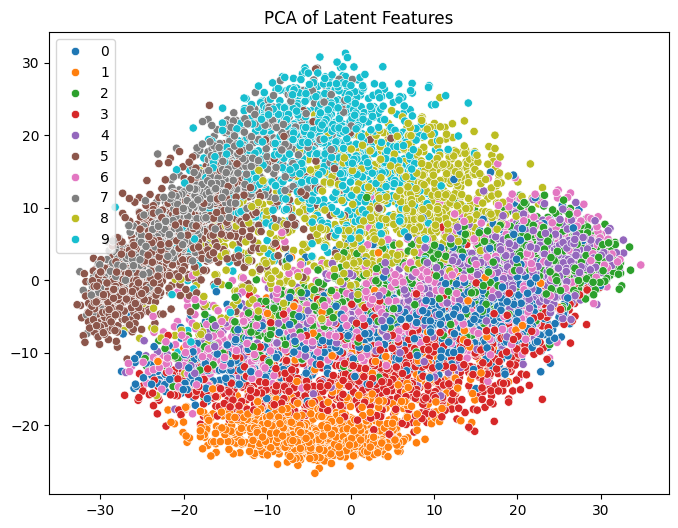

In [6]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="tab10", legend="full")
plt.title('PCA of Latent Features')
plt.show()


In [7]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim=64, num_classes=10):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


In [8]:
classifier = SimpleClassifier(input_dim=64)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    classifier.train()
    train_loss = 0
    for data, label in train_loader:
        _, encoded = autoencoder(data)
        optimizer.zero_grad()
        output = classifier(encoded)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset):.4f}')


Epoch 1, Loss: 0.0043
Epoch 2, Loss: 0.0032
Epoch 3, Loss: 0.0030
Epoch 4, Loss: 0.0028
Epoch 5, Loss: 0.0027


In [9]:
correct = 0
total = 0
classifier.eval()
with torch.no_grad():
    for data, label in test_loader:
        _, encoded = autoencoder(data)
        outputs = classifier(encoded)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print(f'Accuracy with Autoencoder Features: {100 * correct / total:.2f}%')


Accuracy with Autoencoder Features: 86.29%


In [10]:
raw_classifier = SimpleClassifier(input_dim=28 * 28)
optimizer = optim.Adam(raw_classifier.parameters(), lr=0.001)

for epoch in range(epochs):
    raw_classifier.train()
    train_loss = 0
    for data, label in train_loader:
        data = data.view(-1, 28 * 28)
        optimizer.zero_grad()
        output = raw_classifier(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset):.4f}')


Epoch 1, Loss: 0.0042
Epoch 2, Loss: 0.0031
Epoch 3, Loss: 0.0028
Epoch 4, Loss: 0.0026
Epoch 5, Loss: 0.0025


In [11]:
correct = 0
total = 0
raw_classifier.eval()
with torch.no_grad():
    for data, label in test_loader:
        data = data.view(-1, 28 * 28)
        outputs = raw_classifier(data)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print(f'Accuracy with Raw Image Data: {100 * correct / total:.2f}%')


Accuracy with Raw Image Data: 87.09%
